# Example 13 Donor-acceptor relaxation with linear vibronic coupling

**This example takes a while. (a couple of hours)**

- References
  - [Dorfner, Maximilian FX, et al. "Comparison of matrix product state and multiconfiguration time-dependent hartree methods for nonadiabatic dynamics of exciton dissociation." Journal of Chemical Theory and Computation 20.20 (2024): 8767-8781.](https://doi.org/10.1021/acs.jctc.4c00751)

In [1]:
import platform
import sys

import pytdscf

print(sys.version)
print(f"pytdscf version = {pytdscf.__version__}")
print(platform.platform())

import jax.extend

print(jax.extend.backend.get_backend().platform)

3.13.2 (main, Feb  4 2025, 14:51:09) [Clang 16.0.0 (clang-1600.0.26.6)]
pytdscf version = 1.0.4
macOS-15.4.1-x86_64-i386-64bit-Mach-O
cpu


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sympy
from pympo import AssignManager, OpSite, SumOfProducts

from pytdscf import BasInfo, Boson, Exciton, Model, Simulator, units
from pytdscf.dvr_operator_cls import TensorOperator
from pytdscf.hamiltonian_cls import TensorHamiltonian

## Model Hamiltonian

This model contains two electronic states (LE and CS), one intermolecular mode, and 100 effective vibration modes.

$$
\begin{align}
H =& \epsilon_{\text{CS}} |\text{CS}\rangle \langle \text{CS}| + t_{\text{LE,CS}} \left[ |\text{CS}\rangle \langle \text{LE}| + |\text{LE}\rangle \langle \text{CS}| \right] + \sum_{\mu} g^{\mu}_{\text{CS, CS}} |\text{CS}\rangle \langle \text{CS}| (b_{\mu} + b_{\mu}^\dagger) \\ 
 & + g^{R}_{\text{CS, CS}} |\text{CS}\rangle \langle \text{CS}| (b_{R} + b_{R}^\dagger) + g^{R}_{\text{LE, CS}} \left[|\text{CS}\rangle \langle \text{LE}| + |\text{LE}\rangle \langle \text{CS}|\right] (b_{R} + b_{R}^\dagger)\\
 & + \omega_R b_R^\dagger b_R + \sum_{\mu} \omega_{\mu} b_{\mu}^\dagger b_{\mu} 
\end{align}
$$

In [3]:
backend = "numpy"
use_bath = True

epsilon = sympy.Symbol("ε")
t = sympy.Symbol("t_{LE, CS}")
g_cs = sympy.Symbol("g_{CS, CS}")
g_le = sympy.Symbol("g_{LE, CS}")
omega = sympy.Symbol("ω_R")


subs = {}
subs[epsilon] = -0.079 / units.au_in_eV
subs[t] = 0.130 / units.au_in_eV
subs[g_cs] = 0.001 * 30 / (2**0.5) / units.au_in_eV
subs[g_le] = -0.001 * 10 / (2**0.5) / units.au_in_eV
subs[omega] = 0.001 * 10 / units.au_in_eV

if use_bath:
    bath_ω = (
        np.array(
            [
                3.643,
                7.286,
                10.929,
                14.573,
                18.216,
                21.859,
                25.502,
                29.145,
                32.788,
                36.431,
                40.075,
                43.718,
                47.361,
                51.004,
                54.647,
                58.29,
                61.933,
                65.577,
                69.22,
                72.863,
                76.506,
                80.149,
                83.792,
                87.435,
                91.079,
                94.722,
                98.365,
                102.008,
                105.651,
                109.294,
                112.937,
                116.581,
                120.224,
                123.867,
                127.51,
                131.153,
                134.706,
                138.439,
                142.083,
                145.726,
                149.369,
                153.012,
                156.655,
                160.298,
                163.941,
                167.585,
                171.228,
                174.871,
                178.514,
                182.157,
                185.800,
                189.443,
                193.087,
                196.730,
                200.373,
                204.016,
                207.659,
                211.302,
                214.945,
                218.589,
                222.232,
                225.875,
                229.518,
                233.161,
                236.804,
                240.447,
                244.091,
                247.734,
                251.377,
                255.020,
                258.663,
                262.306,
                265.949,
                269.593,
                273.236,
                276.879,
                280.522,
                284.165,
                287.808,
                291.451,
                295.095,
                298.738,
                302.381,
                306.024,
                309.667,
                313.310,
                316.953,
                320.597,
                324.240,
                327.883,
                331.526,
                335.169,
                338.812,
                342.455,
                346.099,
                349.742,
                353.385,
                357.028,
                360.671,
            ]
        )
        / 1000
        / units.au_in_eV
    )

    g_cs2 = (
        np.array(
            [
                2.511,
                2.359,
                2.347,
                2.586,
                3.190,
                4.203,
                5.224,
                5.741,
                5.572,
                5.547,
                6.578,
                8.456,
                9.935,
                10.056,
                9.147,
                8.002,
                7.379,
                8.038,
                10.582,
                14.242,
                17.279,
                18.380,
                17.698,
                15.808,
                13.623,
                12.158,
                11.779,
                12.196,
                13.061,
                13.549,
                12.606,
                10.303,
                8.069,
                7.192,
                7.630,
                8.721,
                9.858,
                10.601,
                10.599,
                10.123,
                10.344,
                12.335,
                15.285,
                16.939,
                16.095,
                14.735,
                15.279,
                19.071,
                26.827,
                38.225,
                47.272,
                47.873,
                43.415,
                39.088,
                34.622,
                28.686,
                22.148,
                16.585,
                12.443,
                9.701,
                8.142,
                7.254,
                6.554,
                5.910,
                5.362,
                4.932,
                4.586,
                4.287,
                4.020,
                3.785,
                3.578,
                3.395,
                3.230,
                3.081,
                2.945,
                2.822,
                2.709,
                2.605,
                2.509,
                2.420,
                2.338,
                2.262,
                2.190,
                2.123,
                2.061,
                2.003,
                1.948,
                1.897,
                1.848,
                1.803,
                1.761,
                1.721,
                1.685,
                1.650,
                1.619,
                1.593,
                1.573,
                1.552,
                1.530,
            ]
        )
        / 1000
        / units.au_in_eV
    )

    ω_symbols = [None]
    g_symbols = [None]
    for i, (ω, g) in enumerate(zip(bath_ω, g_cs2, strict=True)):
        ω_symbols.append(sympy.Symbol(f"omega_{i + 2}"))
        g_symbols.append(sympy.Symbol(f"g_{i + 2}"))
        subs[ω_symbols[-1]] = ω
        subs[g_symbols[-1]] = g

### Setup basis for wavefunction

In [4]:
basis = [
    Exciton(nstate=2, names=["LE", "CS"]),
] + [Boson(nstate=28)] * len(ω_symbols)

basinfo = BasInfo([basis])
ndim = len(basis)
print(ndim)

101


**Note**
- If you want more precise result, it may work to increase nstate of Boson.

### Setup one particle operator

In [5]:
a = basis[0].get_annihilation_matrix()
adag = basis[0].get_creation_matrix()

b = basis[1].get_annihilation_matrix()
bdag = basis[1].get_creation_matrix()

a_op = OpSite("a_0", 0, value=a)
adag_op = OpSite(r"a^\dagger_0", 0, value=adag)

b_ops = [None] + [
    OpSite("b_{" + f"{i}" + "}", i, value=b) for i in range(1, ndim)
]
bdag_ops = [None] + [
    OpSite(r"b^\dagger" + "_{" + f"{i}" + "}", i, value=bdag)
    for i in range(1, ndim)
]

### Setup potential and kinetic operator

In [6]:
pot_sop = SumOfProducts()

pot_sop += adag_op * a_op * epsilon
pot_sop += (a_op + adag_op) * t

pot_sop += g_cs * adag_op * a_op * (b_ops[1] + bdag_ops[1])
pot_sop += g_le * a_op * (b_ops[1] + bdag_ops[1])
pot_sop += g_le * adag_op * (b_ops[1] + bdag_ops[1])
pot_sop += bdag_ops[1] * b_ops[1] * omega

for i in range(2, ndim):
    pot_sop += g_symbols[i - 1] * adag_op * a_op * (b_ops[i] + bdag_ops[i])

for i in range(2, ndim):
    pot_sop += ω_symbols[i - 1] * bdag_ops[i] * b_ops[i]

pot_sop = pot_sop.simplify()
pot_sop.symbol

g_10*a^\dagger_0*a_0*(b^\dagger_{10} + b_{10}) + g_100*a^\dagger_0*a_0*(b^\dagger_{100} + b_{100}) + g_11*a^\dagger_0*a_0*(b^\dagger_{11} + b_{11}) + g_12*a^\dagger_0*a_0*(b^\dagger_{12} + b_{12}) + g_13*a^\dagger_0*a_0*(b^\dagger_{13} + b_{13}) + g_14*a^\dagger_0*a_0*(b^\dagger_{14} + b_{14}) + g_15*a^\dagger_0*a_0*(b^\dagger_{15} + b_{15}) + g_16*a^\dagger_0*a_0*(b^\dagger_{16} + b_{16}) + g_17*a^\dagger_0*a_0*(b^\dagger_{17} + b_{17}) + g_18*a^\dagger_0*a_0*(b^\dagger_{18} + b_{18}) + g_19*a^\dagger_0*a_0*(b^\dagger_{19} + b_{19}) + g_2*a^\dagger_0*a_0*(b^\dagger_{2} + b_{2}) + g_20*a^\dagger_0*a_0*(b^\dagger_{20} + b_{20}) + g_21*a^\dagger_0*a_0*(b^\dagger_{21} + b_{21}) + g_22*a^\dagger_0*a_0*(b^\dagger_{22} + b_{22}) + g_23*a^\dagger_0*a_0*(b^\dagger_{23} + b_{23}) + g_24*a^\dagger_0*a_0*(b^\dagger_{24} + b_{24}) + g_25*a^\dagger_0*a_0*(b^\dagger_{25} + b_{25}) + g_26*a^\dagger_0*a_0*(b^\dagger_{26} + b_{26}) + g_27*a^\dagger_0*a_0*(b^\dagger_{27} + b_{27}) + g_28*a^\dagger_0*a_0

### Setup MPO

In [7]:
am_pot = AssignManager(pot_sop)
am_pot.assign()
display(*am_pot.Wsym)
W_prod = sympy.Mul(*am_pot.Wsym)
print(*[f"W{i}" for i in range(am_pot.ndim)], "=")
display(W_prod[0].expand())
pot_mpo = am_pot.numerical_mpo(subs=subs)

2025-04-29 02:11:20.898 | INFO     | pympo.bipartite:assign:286 - assigned 1/101
2025-04-29 02:11:20.935 | INFO     | pympo.bipartite:assign:286 - assigned 2/101
2025-04-29 02:11:20.985 | INFO     | pympo.bipartite:assign:286 - assigned 3/101
2025-04-29 02:11:21.045 | INFO     | pympo.bipartite:assign:286 - assigned 4/101
2025-04-29 02:11:21.082 | INFO     | pympo.bipartite:assign:286 - assigned 5/101
2025-04-29 02:11:21.122 | INFO     | pympo.bipartite:assign:286 - assigned 6/101
2025-04-29 02:11:21.167 | INFO     | pympo.bipartite:assign:286 - assigned 7/101
2025-04-29 02:11:21.214 | INFO     | pympo.bipartite:assign:286 - assigned 8/101
2025-04-29 02:11:21.249 | INFO     | pympo.bipartite:assign:286 - assigned 9/101
2025-04-29 02:11:21.286 | INFO     | pympo.bipartite:assign:286 - assigned 10/101
2025-04-29 02:11:21.327 | INFO     | pympo.bipartite:assign:286 - assigned 11/101
2025-04-29 02:11:21.371 | INFO     | pympo.bipartite:assign:286 - assigned 12/101
2025-04-29 02:11:21.412 |

Matrix([[a^\dagger_0*a_0, 1, a^\dagger_0 + a_0, g_{LE, CS}*a^\dagger_0 + g_{LE, CS}*a_0]])

Matrix([
[0, 1, g_{CS, CS}*(b^\dagger_{1} + b_{1})],
[1, 0,            ω_R*b^\dagger_{1}*b_{1}],
[0, 0,                         t_{LE, CS}],
[0, 0,              b^\dagger_{1} + b_{1}]])

Matrix([
[1, 0, omega_2*b^\dagger_{2}*b_{2}],
[0, 1, g_2*(b^\dagger_{2} + b_{2})],
[0, 0,                           1]])

Matrix([
[1, 0, omega_3*b^\dagger_{3}*b_{3}],
[0, 1, g_3*(b^\dagger_{3} + b_{3})],
[0, 0,                           1]])

Matrix([
[1, 0, omega_4*b^\dagger_{4}*b_{4}],
[0, 1, g_4*(b^\dagger_{4} + b_{4})],
[0, 0,                           1]])

Matrix([
[0, 1, omega_5*b^\dagger_{5}*b_{5}],
[1, 0, g_5*(b^\dagger_{5} + b_{5})],
[0, 0,                           1]])

Matrix([
[1, 0, g_6*(b^\dagger_{6} + b_{6})],
[0, 1, omega_6*b^\dagger_{6}*b_{6}],
[0, 0,                           1]])

Matrix([
[1, 0, g_7*(b^\dagger_{7} + b_{7})],
[0, 1, omega_7*b^\dagger_{7}*b_{7}],
[0, 0,                           1]])

Matrix([
[0, 1, g_8*(b^\dagger_{8} + b_{8})],
[1, 0, omega_8*b^\dagger_{8}*b_{8}],
[0, 0,                           1]])

Matrix([
[0, 1, omega_9*b^\dagger_{9}*b_{9}],
[1, 0, g_9*(b^\dagger_{9} + b_{9})],
[0, 0,                           1]])

Matrix([
[1, 0, g_10*(b^\dagger_{10} + b_{10})],
[0, 1, omega_10*b^\dagger_{10}*b_{10}],
[0, 0,                              1]])

Matrix([
[1, 0, g_11*(b^\dagger_{11} + b_{11})],
[0, 1, omega_11*b^\dagger_{11}*b_{11}],
[0, 0,                              1]])

Matrix([
[0, 1, g_12*(b^\dagger_{12} + b_{12})],
[1, 0, omega_12*b^\dagger_{12}*b_{12}],
[0, 0,                              1]])

Matrix([
[1, 0, omega_13*b^\dagger_{13}*b_{13}],
[0, 1, g_13*(b^\dagger_{13} + b_{13})],
[0, 0,                              1]])

Matrix([
[0, 1, omega_14*b^\dagger_{14}*b_{14}],
[1, 0, g_14*(b^\dagger_{14} + b_{14})],
[0, 0,                              1]])

Matrix([
[1, 0, g_15*(b^\dagger_{15} + b_{15})],
[0, 1, omega_15*b^\dagger_{15}*b_{15}],
[0, 0,                              1]])

Matrix([
[1, 0, g_16*(b^\dagger_{16} + b_{16})],
[0, 1, omega_16*b^\dagger_{16}*b_{16}],
[0, 0,                              1]])

Matrix([
[1, 0, g_17*(b^\dagger_{17} + b_{17})],
[0, 1, omega_17*b^\dagger_{17}*b_{17}],
[0, 0,                              1]])

Matrix([
[1, 0, g_18*(b^\dagger_{18} + b_{18})],
[0, 1, omega_18*b^\dagger_{18}*b_{18}],
[0, 0,                              1]])

Matrix([
[1, 0, g_19*(b^\dagger_{19} + b_{19})],
[0, 1, omega_19*b^\dagger_{19}*b_{19}],
[0, 0,                              1]])

Matrix([
[1, 0, g_20*(b^\dagger_{20} + b_{20})],
[0, 1, omega_20*b^\dagger_{20}*b_{20}],
[0, 0,                              1]])

Matrix([
[0, 1, g_21*(b^\dagger_{21} + b_{21})],
[1, 0, omega_21*b^\dagger_{21}*b_{21}],
[0, 0,                              1]])

Matrix([
[0, 1, omega_22*b^\dagger_{22}*b_{22}],
[1, 0, g_22*(b^\dagger_{22} + b_{22})],
[0, 0,                              1]])

Matrix([
[1, 0, g_23*(b^\dagger_{23} + b_{23})],
[0, 1, omega_23*b^\dagger_{23}*b_{23}],
[0, 0,                              1]])

Matrix([
[1, 0, g_24*(b^\dagger_{24} + b_{24})],
[0, 1, omega_24*b^\dagger_{24}*b_{24}],
[0, 0,                              1]])

Matrix([
[1, 0, g_25*(b^\dagger_{25} + b_{25})],
[0, 1, omega_25*b^\dagger_{25}*b_{25}],
[0, 0,                              1]])

Matrix([
[1, 0, g_26*(b^\dagger_{26} + b_{26})],
[0, 1, omega_26*b^\dagger_{26}*b_{26}],
[0, 0,                              1]])

Matrix([
[1, 0, g_27*(b^\dagger_{27} + b_{27})],
[0, 1, omega_27*b^\dagger_{27}*b_{27}],
[0, 0,                              1]])

Matrix([
[1, 0, g_28*(b^\dagger_{28} + b_{28})],
[0, 1, omega_28*b^\dagger_{28}*b_{28}],
[0, 0,                              1]])

Matrix([
[1, 0, g_29*(b^\dagger_{29} + b_{29})],
[0, 1, omega_29*b^\dagger_{29}*b_{29}],
[0, 0,                              1]])

Matrix([
[1, 0, g_30*(b^\dagger_{30} + b_{30})],
[0, 1, omega_30*b^\dagger_{30}*b_{30}],
[0, 0,                              1]])

Matrix([
[1, 0, g_31*(b^\dagger_{31} + b_{31})],
[0, 1, omega_31*b^\dagger_{31}*b_{31}],
[0, 0,                              1]])

Matrix([
[0, 1, g_32*(b^\dagger_{32} + b_{32})],
[1, 0, omega_32*b^\dagger_{32}*b_{32}],
[0, 0,                              1]])

Matrix([
[1, 0, omega_33*b^\dagger_{33}*b_{33}],
[0, 1, g_33*(b^\dagger_{33} + b_{33})],
[0, 0,                              1]])

Matrix([
[0, 1, omega_34*b^\dagger_{34}*b_{34}],
[1, 0, g_34*(b^\dagger_{34} + b_{34})],
[0, 0,                              1]])

Matrix([
[0, 1, g_35*(b^\dagger_{35} + b_{35})],
[1, 0, omega_35*b^\dagger_{35}*b_{35}],
[0, 0,                              1]])

Matrix([
[1, 0, omega_36*b^\dagger_{36}*b_{36}],
[0, 1, g_36*(b^\dagger_{36} + b_{36})],
[0, 0,                              1]])

Matrix([
[1, 0, omega_37*b^\dagger_{37}*b_{37}],
[0, 1, g_37*(b^\dagger_{37} + b_{37})],
[0, 0,                              1]])

Matrix([
[0, 1, omega_38*b^\dagger_{38}*b_{38}],
[1, 0, g_38*(b^\dagger_{38} + b_{38})],
[0, 0,                              1]])

Matrix([
[0, 1, g_39*(b^\dagger_{39} + b_{39})],
[1, 0, omega_39*b^\dagger_{39}*b_{39}],
[0, 0,                              1]])

Matrix([
[0, 1, omega_40*b^\dagger_{40}*b_{40}],
[1, 0, g_40*(b^\dagger_{40} + b_{40})],
[0, 0,                              1]])

Matrix([
[1, 0, g_41*(b^\dagger_{41} + b_{41})],
[0, 1, omega_41*b^\dagger_{41}*b_{41}],
[0, 0,                              1]])

Matrix([
[1, 0, g_42*(b^\dagger_{42} + b_{42})],
[0, 1, omega_42*b^\dagger_{42}*b_{42}],
[0, 0,                              1]])

Matrix([
[0, 1, g_43*(b^\dagger_{43} + b_{43})],
[1, 0, omega_43*b^\dagger_{43}*b_{43}],
[0, 0,                              1]])

Matrix([
[1, 0, omega_44*b^\dagger_{44}*b_{44}],
[0, 1, g_44*(b^\dagger_{44} + b_{44})],
[0, 0,                              1]])

Matrix([
[0, 1, omega_45*b^\dagger_{45}*b_{45}],
[1, 0, g_45*(b^\dagger_{45} + b_{45})],
[0, 0,                              1]])

Matrix([
[1, 0, g_46*(b^\dagger_{46} + b_{46})],
[0, 1, omega_46*b^\dagger_{46}*b_{46}],
[0, 0,                              1]])

Matrix([
[0, 1, g_47*(b^\dagger_{47} + b_{47})],
[1, 0, omega_47*b^\dagger_{47}*b_{47}],
[0, 0,                              1]])

Matrix([
[1, 0, omega_48*b^\dagger_{48}*b_{48}],
[0, 1, g_48*(b^\dagger_{48} + b_{48})],
[0, 0,                              1]])

Matrix([
[0, 1, omega_49*b^\dagger_{49}*b_{49}],
[1, 0, g_49*(b^\dagger_{49} + b_{49})],
[0, 0,                              1]])

Matrix([
[0, 1, g_50*(b^\dagger_{50} + b_{50})],
[1, 0, omega_50*b^\dagger_{50}*b_{50}],
[0, 0,                              1]])

Matrix([
[0, 1, omega_51*b^\dagger_{51}*b_{51}],
[1, 0, g_51*(b^\dagger_{51} + b_{51})],
[0, 0,                              1]])

Matrix([
[0, 1, g_52*(b^\dagger_{52} + b_{52})],
[1, 0, omega_52*b^\dagger_{52}*b_{52}],
[0, 0,                              1]])

Matrix([
[0, 1, omega_53*b^\dagger_{53}*b_{53}],
[1, 0, g_53*(b^\dagger_{53} + b_{53})],
[0, 0,                              1]])

Matrix([
[0, 1, g_54*(b^\dagger_{54} + b_{54})],
[1, 0, omega_54*b^\dagger_{54}*b_{54}],
[0, 0,                              1]])

Matrix([
[0, 1, omega_55*b^\dagger_{55}*b_{55}],
[1, 0, g_55*(b^\dagger_{55} + b_{55})],
[0, 0,                              1]])

Matrix([
[0, 1, g_56*(b^\dagger_{56} + b_{56})],
[1, 0, omega_56*b^\dagger_{56}*b_{56}],
[0, 0,                              1]])

Matrix([
[0, 1, omega_57*b^\dagger_{57}*b_{57}],
[1, 0, g_57*(b^\dagger_{57} + b_{57})],
[0, 0,                              1]])

Matrix([
[1, 0, g_58*(b^\dagger_{58} + b_{58})],
[0, 1, omega_58*b^\dagger_{58}*b_{58}],
[0, 0,                              1]])

Matrix([
[1, 0, g_59*(b^\dagger_{59} + b_{59})],
[0, 1, omega_59*b^\dagger_{59}*b_{59}],
[0, 0,                              1]])

Matrix([
[0, 1, g_60*(b^\dagger_{60} + b_{60})],
[1, 0, omega_60*b^\dagger_{60}*b_{60}],
[0, 0,                              1]])

Matrix([
[0, 1, omega_61*b^\dagger_{61}*b_{61}],
[1, 0, g_61*(b^\dagger_{61} + b_{61})],
[0, 0,                              1]])

Matrix([
[0, 1, g_62*(b^\dagger_{62} + b_{62})],
[1, 0, omega_62*b^\dagger_{62}*b_{62}],
[0, 0,                              1]])

Matrix([
[1, 0, omega_63*b^\dagger_{63}*b_{63}],
[0, 1, g_63*(b^\dagger_{63} + b_{63})],
[0, 0,                              1]])

Matrix([
[0, 1, omega_64*b^\dagger_{64}*b_{64}],
[1, 0, g_64*(b^\dagger_{64} + b_{64})],
[0, 0,                              1]])

Matrix([
[0, 1, g_65*(b^\dagger_{65} + b_{65})],
[1, 0, omega_65*b^\dagger_{65}*b_{65}],
[0, 0,                              1]])

Matrix([
[1, 0, omega_66*b^\dagger_{66}*b_{66}],
[0, 1, g_66*(b^\dagger_{66} + b_{66})],
[0, 0,                              1]])

Matrix([
[1, 0, omega_67*b^\dagger_{67}*b_{67}],
[0, 1, g_67*(b^\dagger_{67} + b_{67})],
[0, 0,                              1]])

Matrix([
[0, 1, omega_68*b^\dagger_{68}*b_{68}],
[1, 0, g_68*(b^\dagger_{68} + b_{68})],
[0, 0,                              1]])

Matrix([
[1, 0, g_69*(b^\dagger_{69} + b_{69})],
[0, 1, omega_69*b^\dagger_{69}*b_{69}],
[0, 0,                              1]])

Matrix([
[0, 1, g_70*(b^\dagger_{70} + b_{70})],
[1, 0, omega_70*b^\dagger_{70}*b_{70}],
[0, 0,                              1]])

Matrix([
[0, 1, omega_71*b^\dagger_{71}*b_{71}],
[1, 0, g_71*(b^\dagger_{71} + b_{71})],
[0, 0,                              1]])

Matrix([
[0, 1, g_72*(b^\dagger_{72} + b_{72})],
[1, 0, omega_72*b^\dagger_{72}*b_{72}],
[0, 0,                              1]])

Matrix([
[1, 0, omega_73*b^\dagger_{73}*b_{73}],
[0, 1, g_73*(b^\dagger_{73} + b_{73})],
[0, 0,                              1]])

Matrix([
[1, 0, omega_74*b^\dagger_{74}*b_{74}],
[0, 1, g_74*(b^\dagger_{74} + b_{74})],
[0, 0,                              1]])

Matrix([
[0, 1, omega_75*b^\dagger_{75}*b_{75}],
[1, 0, g_75*(b^\dagger_{75} + b_{75})],
[0, 0,                              1]])

Matrix([
[1, 0, g_76*(b^\dagger_{76} + b_{76})],
[0, 1, omega_76*b^\dagger_{76}*b_{76}],
[0, 0,                              1]])

Matrix([
[1, 0, g_77*(b^\dagger_{77} + b_{77})],
[0, 1, omega_77*b^\dagger_{77}*b_{77}],
[0, 0,                              1]])

Matrix([
[1, 0, g_78*(b^\dagger_{78} + b_{78})],
[0, 1, omega_78*b^\dagger_{78}*b_{78}],
[0, 0,                              1]])

Matrix([
[1, 0, g_79*(b^\dagger_{79} + b_{79})],
[0, 1, omega_79*b^\dagger_{79}*b_{79}],
[0, 0,                              1]])

Matrix([
[1, 0, g_80*(b^\dagger_{80} + b_{80})],
[0, 1, omega_80*b^\dagger_{80}*b_{80}],
[0, 0,                              1]])

Matrix([
[0, 1, g_81*(b^\dagger_{81} + b_{81})],
[1, 0, omega_81*b^\dagger_{81}*b_{81}],
[0, 0,                              1]])

Matrix([
[0, 1, omega_82*b^\dagger_{82}*b_{82}],
[1, 0, g_82*(b^\dagger_{82} + b_{82})],
[0, 0,                              1]])

Matrix([
[1, 0, g_83*(b^\dagger_{83} + b_{83})],
[0, 1, omega_83*b^\dagger_{83}*b_{83}],
[0, 0,                              1]])

Matrix([
[1, 0, g_84*(b^\dagger_{84} + b_{84})],
[0, 1, omega_84*b^\dagger_{84}*b_{84}],
[0, 0,                              1]])

Matrix([
[0, 1, g_85*(b^\dagger_{85} + b_{85})],
[1, 0, omega_85*b^\dagger_{85}*b_{85}],
[0, 0,                              1]])

Matrix([
[0, 1, omega_86*b^\dagger_{86}*b_{86}],
[1, 0, g_86*(b^\dagger_{86} + b_{86})],
[0, 0,                              1]])

Matrix([
[0, 1, g_87*(b^\dagger_{87} + b_{87})],
[1, 0, omega_87*b^\dagger_{87}*b_{87}],
[0, 0,                              1]])

Matrix([
[1, 0, omega_88*b^\dagger_{88}*b_{88}],
[0, 1, g_88*(b^\dagger_{88} + b_{88})],
[0, 0,                              1]])

Matrix([
[1, 0, omega_89*b^\dagger_{89}*b_{89}],
[0, 1, g_89*(b^\dagger_{89} + b_{89})],
[0, 0,                              1]])

Matrix([
[0, 1, omega_90*b^\dagger_{90}*b_{90}],
[1, 0, g_90*(b^\dagger_{90} + b_{90})],
[0, 0,                              1]])

Matrix([
[0, 1, g_91*(b^\dagger_{91} + b_{91})],
[1, 0, omega_91*b^\dagger_{91}*b_{91}],
[0, 0,                              1]])

Matrix([
[0, 1, omega_92*b^\dagger_{92}*b_{92}],
[1, 0, g_92*(b^\dagger_{92} + b_{92})],
[0, 0,                              1]])

Matrix([
[0, 1, g_93*(b^\dagger_{93} + b_{93})],
[1, 0, omega_93*b^\dagger_{93}*b_{93}],
[0, 0,                              1]])

Matrix([
[1, 0, omega_94*b^\dagger_{94}*b_{94}],
[0, 1, g_94*(b^\dagger_{94} + b_{94})],
[0, 0,                              1]])

Matrix([
[1, 0, omega_95*b^\dagger_{95}*b_{95}],
[0, 1, g_95*(b^\dagger_{95} + b_{95})],
[0, 0,                              1]])

Matrix([
[1, 0, omega_96*b^\dagger_{96}*b_{96}],
[0, 1, g_96*(b^\dagger_{96} + b_{96})],
[0, 0,                              1]])

Matrix([
[1, 0, omega_97*b^\dagger_{97}*b_{97}],
[0, 1, g_97*(b^\dagger_{97} + b_{97})],
[0, 0,                              1]])

Matrix([
[1, 0, omega_98*b^\dagger_{98}*b_{98}],
[0, 1, g_98*(b^\dagger_{98} + b_{98})],
[0, 0,                              1]])

Matrix([
[0, 1, omega_99*b^\dagger_{99}*b_{99}],
[1, 0, g_99*(b^\dagger_{99} + b_{99})],
[0, 0,                              1]])

Matrix([
[g_100*(b^\dagger_{100} + b_{100}) + ε],
[    omega_100*b^\dagger_{100}*b_{100}],
[                                    1]])

W0 W1 W2 W3 W4 W5 W6 W7 W8 W9 W10 W11 W12 W13 W14 W15 W16 W17 W18 W19 W20 W21 W22 W23 W24 W25 W26 W27 W28 W29 W30 W31 W32 W33 W34 W35 W36 W37 W38 W39 W40 W41 W42 W43 W44 W45 W46 W47 W48 W49 W50 W51 W52 W53 W54 W55 W56 W57 W58 W59 W60 W61 W62 W63 W64 W65 W66 W67 W68 W69 W70 W71 W72 W73 W74 W75 W76 W77 W78 W79 W80 W81 W82 W83 W84 W85 W86 W87 W88 W89 W90 W91 W92 W93 W94 W95 W96 W97 W98 W99 W100 =


g_10*a^\dagger_0*a_0*b^\dagger_{10} + g_10*a^\dagger_0*a_0*b_{10} + g_100*a^\dagger_0*a_0*b^\dagger_{100} + g_100*a^\dagger_0*a_0*b_{100} + g_11*a^\dagger_0*a_0*b^\dagger_{11} + g_11*a^\dagger_0*a_0*b_{11} + g_12*a^\dagger_0*a_0*b^\dagger_{12} + g_12*a^\dagger_0*a_0*b_{12} + g_13*a^\dagger_0*a_0*b^\dagger_{13} + g_13*a^\dagger_0*a_0*b_{13} + g_14*a^\dagger_0*a_0*b^\dagger_{14} + g_14*a^\dagger_0*a_0*b_{14} + g_15*a^\dagger_0*a_0*b^\dagger_{15} + g_15*a^\dagger_0*a_0*b_{15} + g_16*a^\dagger_0*a_0*b^\dagger_{16} + g_16*a^\dagger_0*a_0*b_{16} + g_17*a^\dagger_0*a_0*b^\dagger_{17} + g_17*a^\dagger_0*a_0*b_{17} + g_18*a^\dagger_0*a_0*b^\dagger_{18} + g_18*a^\dagger_0*a_0*b_{18} + g_19*a^\dagger_0*a_0*b^\dagger_{19} + g_19*a^\dagger_0*a_0*b_{19} + g_2*a^\dagger_0*a_0*b^\dagger_{2} + g_2*a^\dagger_0*a_0*b_{2} + g_20*a^\dagger_0*a_0*b^\dagger_{20} + g_20*a^\dagger_0*a_0*b_{20} + g_21*a^\dagger_0*a_0*b^\dagger_{21} + g_21*a^\dagger_0*a_0*b_{21} + g_22*a^\dagger_0*a_0*b^\dagger_{22} + g_22*a^\da

### Setup Hamiltonian

In [8]:
potential = [
    [{(tuple((i, i) for i in range(0, ndim))): TensorOperator(mpo=pot_mpo)}]
]

H = TensorHamiltonian(
    ndof=len(basis), potential=potential, kinetic=None, backend=backend
)

operators = {"hamiltonian": H}

for i in range(1, ndim):
    core = np.zeros((1, basis[i].nprim, 1))
    core[0, :, 0] = np.arange(basis[i].nprim)
    n = TensorHamiltonian(
        ndof=len(basis),
        potential=[[{(i,): TensorOperator(mpo=[core], legs=(i,))}]],
        kinetic=None,
        backend=backend,
    )
    operators[f"N{i}"] = n

### Setup Model (basis, operators, initial states)

In [9]:
model = Model(basinfo=basinfo, operators=operators)
model.m_aux_max = 20
init_boson = [[1.0] + [0.0] * (basis[1].nprim - 1)]
model.init_HartreeProduct = [[[1.0, 0.0]] + init_boson * (ndim - 1)]

### Execution

In [10]:
jobname = "donor-acceptor_model-A"
simulator = Simulator(jobname=jobname, model=model, backend=backend, verbose=2)
simulator.propagate(
    maxstep=1000,
    stepsize=0.2,
    reduced_density=(
        [(0, 0)],
        10,
    ),
    energy=True,
    autocorr=False,
    observables=True,
    observables_per_step=10,
)

2025-04-29 02:11:27,869 - INFO:main.pytdscf._const_cls - 
     ____     __________   .____ ____   _____
    / _  |   /__  __/ _ \ / ___ / _  \ / ___/
   / /_) /_  __/ / / / ||/ /__ / / )_// /__
  /  ___/ / / / / / / / |.__  / |  __/ ___/
 /  /  / /_/ / / / /_/ /___/ /| \_/ / /
/__/   \__, /_/ /_____/_____/ \____/_/
      /____/

2025-04-29 02:11:27,871 - INFO:main.pytdscf._const_cls - Log file is ./donor-acceptor_model-A_prop/main.log
2025-04-29 02:11:27,872 - INFO:main.pytdscf.simulator_cls - Set integral of FBR basis
2025-04-29 02:11:27,878 - INFO:main.pytdscf.simulator_cls - Set initial wave function (FBR basis)
2025-04-29 02:11:27,879 - INFO:main.pytdscf.simulator_cls - Prepare MPS w.f.
2025-04-29 02:11:27,882 - INFO:main.pytdscf._mps_cls - Initial MPS: 0-state with weights 1.0
2025-04-29 02:11:28,173 - INFO:main.pytdscf.simulator_cls - Wave function is saved in wf_donor-acceptor_model-A.pkl
2025-04-29 02:11:28,221 - INFO:main.pytdscf.simulator_cls - Start initial step    0.000 [fs

(-2.8211260824433874e-09, <pytdscf.wavefunction.WFunc at 0x11975cad0>)

### Check results (reduced densities)

In [11]:
import netCDF4 as nc

with nc.Dataset(f"{jobname}_prop/reduced_density.nc", "r") as file:
    density_data_real = file.variables["rho_(0, 0)_0"][:]["real"]
    density_data_imag = file.variables["rho_(0, 0)_0"][:]["imag"]
    time_data = file.variables["time"][:]

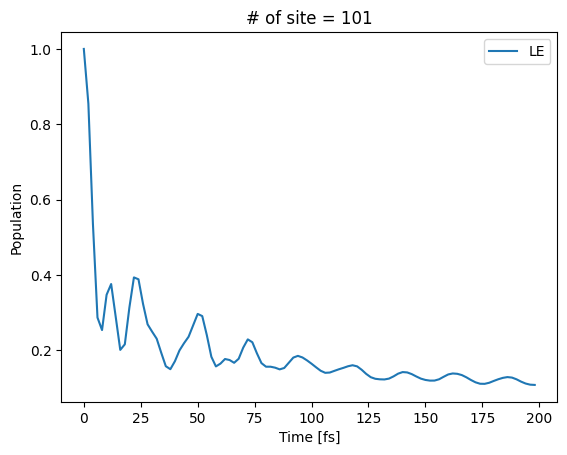

In [12]:
plt.title(f"# of site = {len(basis)}")
plt.ylabel("Population")
plt.xlabel("Time [fs]")
plt.plot(time_data, density_data_real[:, 0, 0], label="LE")
plt.legend()
plt.show()

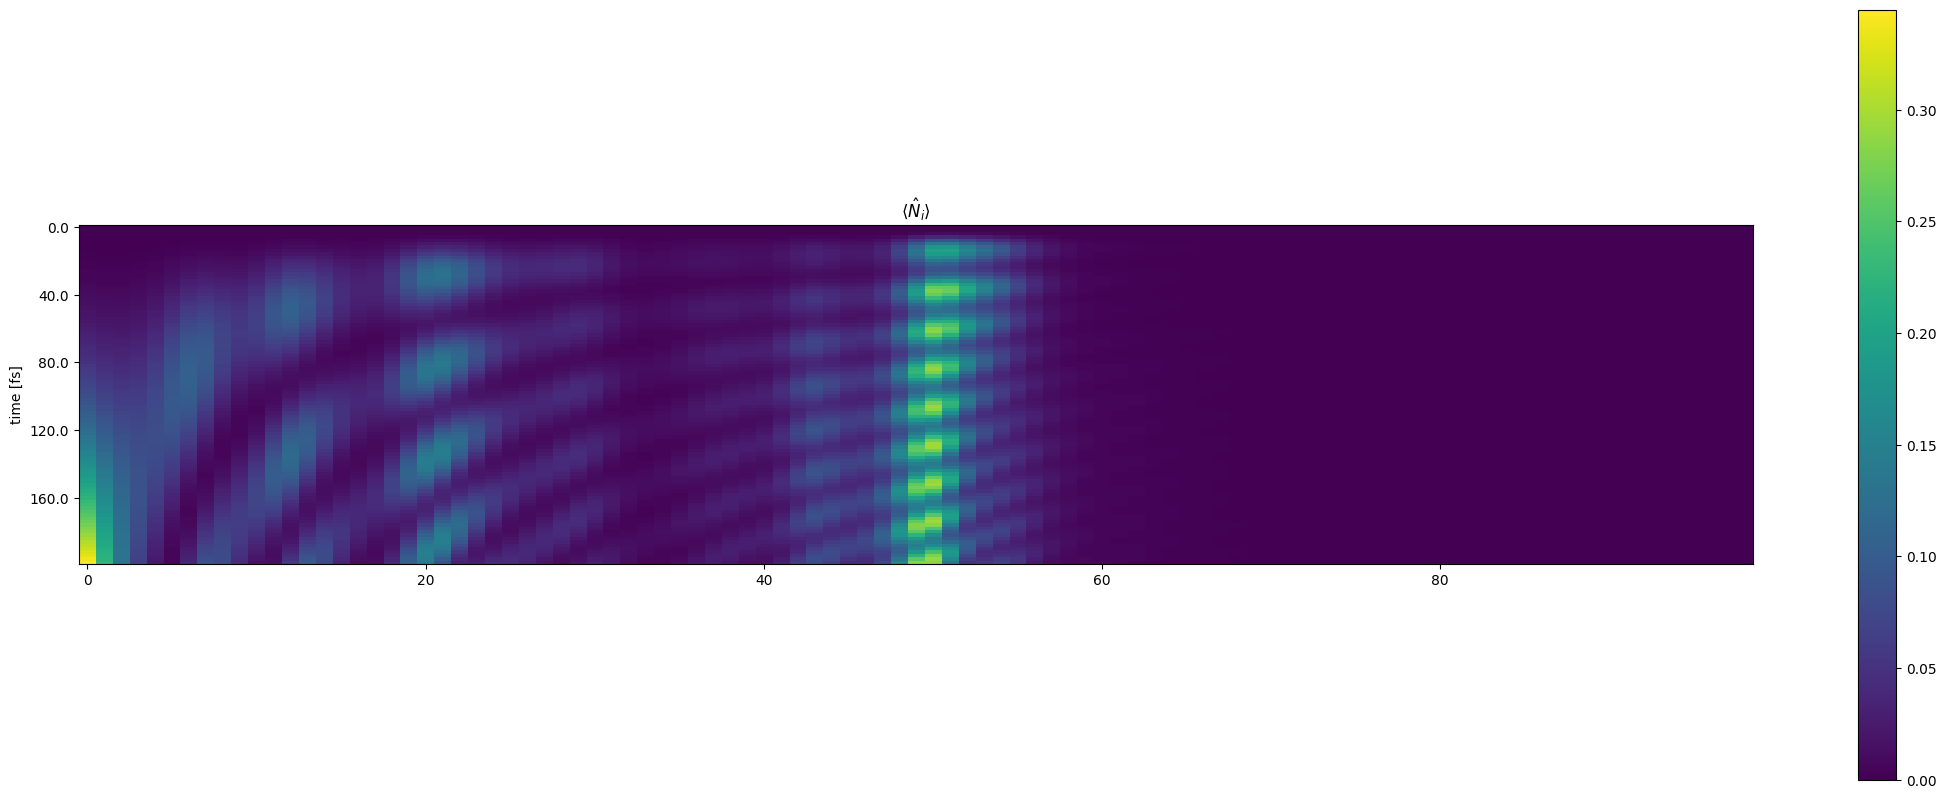

In [13]:
import re

import polars as pl

path = f"{jobname}_prop/expectations.dat"
with open(path, "r") as f:
    header = f.readline().strip()
    columns = re.split(r"\s+", header)

    columns.pop(2)

    columns = [columns[1]] + columns[2:]

    data = f.readlines()

df = pl.read_csv(
    path,
    separator="\t",
    new_columns=columns,
    has_header=False,
    skip_rows=1,
    schema_overrides={col: pl.Float64 for col in columns},
)

plt.figure(figsize=(27, 10))
plt.imshow(df[columns[2:]], aspect=0.2)
plt.colorbar()
plt.yticks(np.arange(len(df))[::20], df["time"][::20])
plt.ylabel("time [fs]")
plt.title(r"$\langle \hat{N}_i \rangle$")
plt.show()

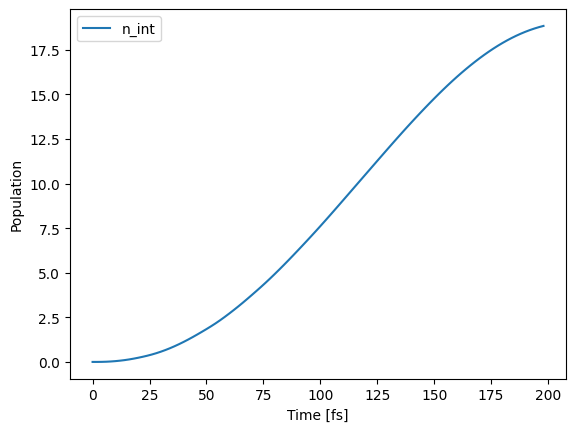

In [ ]:
plt.ylabel("Population")
plt.xlabel("Time [fs]")
plt.plot(time_data, df[columns[1]], label="n_int")  # Intermolecular mode
plt.legend()
plt.show()